# Benchmarking Route Calculation Function
This notebook presents an analysis of 250 iterations of the route calculation function used by the app. Locations and times were randomly selected. The timing data for this analysis was generated using the `benchmarking_generator.py` script.

 ## 0. Load libraries

In [66]:
import pandas as pd
from pandas.plotting import parallel_coordinates
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## 1. Load data

In [67]:
# Load the CSV file into a DataFrame
df_path = os.path.join(os.getcwd(), 'benchmark_data.csv')
df = pd.read_csv(df_path)

# Check the first few rows of the DataFrame
display(df.head())

,t00_start,t01_load_coords,t02_get_sun_vector,t03_get_existing_sun_vector,t04_load_weighted_graph,t05_calculate_routes,t06_remove_repeated_routes,t07_convert_routes_to_coordinates,t08_calculate_routes_metrics,t09_load_shadows,t10_render_map
0,0.0,3.417866,3.542445,3.542445,7.220036,16.477430,16.477430,16.494603,17.166010,23.020021,29.872883
1,0.0,2.852058,2.852058,2.852058,7.526284,19.127371,19.127371,19.127371,19.648858,23.393537,39.108896
2,0.0,2.865185,2.880813,2.880813,7.709015,20.570581,20.570581,20.570581,20.893893,25.646569,35.864213
3,0.0,2.802001,2.802001,2.802001,7.075559,14.775236,14.775236,14.775236,15.247870,18.559804,19.150269
4,0.0,2.712423,2.728043,2.728043,7.151644,14.348046,14.348046,14.348046,14.421949,18.949622,19.994117


The following table describes the columns of the `df` DataFrame, which contains the times (in seconds) recorded at each stage of the route calculation process for 250 iterations. These stages are executed sequentially and independently. Each row represents an execution stage of the algorithm, allowing for analysis of performance and bottlenecks at each step of the workflow.

| Name                              | Description                                                                                          | Example(s)   |
|-----------------------------------|------------------------------------------------------------------------------------------------------|--------------|
| t00_start                         | Start time (seconds)                                                                                 | 0.0          |
| t01_load_coords                   | Coordinate loading time (seconds) from t00                                                           | 3.417866     |
| t02_get_sun_vector                | Time to calculate the corresponding sun vector (seconds) from t00                                    | 3.542445     |
| t03_get_existing_sun_vector       | Time to determine the closest sun vector from calculated data (seconds) from t00                     | 3.542445     |
| t04_load_weighted_graph           | Weighted graph loading time (seconds) from t00                                                       | 7.220036     |
| t05_calculate_routes              | Route calculation time (seconds) from t00                                                            | 16.477430    |
| t06_remove_repeated_routes        | Time to remove repeated routes (seconds) from t00                                                    | 16.477430    |
| t07_convert_routes_to_coordinates | Time to convert routes to coordinates (seconds) from t00                                             | 16.494603    |
| t08_calculate_routes_metrics      | Time to calculate route metrics (seconds) from t00                                                   | 17.166010    |
| t09_load_shadows                  | Shadow loading time (seconds) from t00                                                               | 23.020021    |
| t10_render_map                    | Map rendering time (seconds) from t00                                                                | 29.872883    |

## 2. Data Preprocessing
The data is prepared by creating a new column called `total_duration` for each row in the DataFrame, which represents the total execution time of the test (corresponding to the value in the `t10_render_map` column). Next, the columns are processed to calculate the duration of each individual stage (instead of the current cumulative times from the initial instant).

In [68]:
# Copy the DataFrame to a new variable
df_proc = df.copy()

# Keep the total duration storing it in a new column
total_duration = df_proc['t10_render_map']

# Get the columns that are going to be used in the duration calculation
columns = df_proc.columns.tolist()

# Calculate the difference between consecutive columns
df_proc[columns] = df_proc[columns].diff(axis=1)

# Drop the t00_start column and add the total duration column
df_proc.drop(columns=['t00_start'], inplace=True)
df_proc['total_duration'] = total_duration

# Show the head of the processed DataFrame
df_proc = df_proc.round(4)
display(df_proc.head())

,t01_load_coords,t02_get_sun_vector,t03_get_existing_sun_vector,t04_load_weighted_graph,t05_calculate_routes,t06_remove_repeated_routes,t07_convert_routes_to_coordinates,t08_calculate_routes_metrics,t09_load_shadows,t10_render_map,total_duration
0,3.4179,0.1246,0.0,3.6776,9.2574,0.0,0.0172,0.6714,5.8540,6.8529,29.8729
1,2.8521,0.0000,0.0,4.6742,11.6011,0.0,0.0000,0.5215,3.7447,15.7154,39.1089
2,2.8652,0.0156,0.0,4.8282,12.8616,0.0,0.0000,0.3233,4.7527,10.2176,35.8642
3,2.8020,0.0000,0.0,4.2736,7.6997,0.0,0.0000,0.4726,3.3119,0.5905,19.1503
4,2.7124,0.0156,0.0,4.4236,7.1964,0.0,0.0000,0.0739,4.5277,1.0445,19.9941


Display column information to verify data types and check for missing values in the processed DataFrame. This helps ensure the data is clean and ready for further analysis.

In [69]:
df_proc.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 11 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   t01_load_coords                    250 non-null    float64
 1   t02_get_sun_vector                 250 non-null    float64
 2   t03_get_existing_sun_vector        250 non-null    float64
 3   t04_load_weighted_graph            250 non-null    float64
 4   t05_calculate_routes               250 non-null    float64
 5   t06_remove_repeated_routes         250 non-null    float64
 6   t07_convert_routes_to_coordinates  250 non-null    float64
 7   t08_calculate_routes_metrics       250 non-null    float64
 8   t09_load_shadows                   250 non-null    float64
 9   t10_render_map                     250 non-null    float64
 10  total_duration                     250 non-null    float64
dtypes: float64(11)
memory usage: 21.6 KB


The results show that the processed DataFrame (df_proc) contains 250 rows and 11 columns, all with non-null values (non-null count = 250). This indicates that there are no missing values in the data. Additionally, all columns have the data type float64, which is suitable for numerical analysis and computations.



## 3. Data analysis

In [70]:
# Basic statistical descriptors of the processed DataFrame
display(df_proc.describe().round(4).T)

,count,mean,std,min,25%,50%,75%,max
t01_load_coords,250.0,3.0862,0.2116,2.7124,2.9903,3.0639,3.1254,4.8332
t02_get_sun_vector,250.0,0.0031,0.0096,0.0000,0.0000,0.0000,0.0000,0.1246
t03_get_existing_sun_vector,250.0,0.0017,0.0051,0.0000,0.0000,0.0000,0.0000,0.0315
t04_load_weighted_graph,250.0,5.0853,1.5903,3.6776,4.6328,4.8208,5.0112,14.5613
t05_calculate_routes,250.0,9.9244,2.6218,6.6492,7.8702,8.8650,11.4493,18.3391
t06_remove_repeated_routes,250.0,0.0006,0.0031,0.0000,0.0000,0.0000,0.0000,0.0156
t07_convert_routes_to_coordinates,250.0,0.0090,0.0217,0.0000,0.0000,0.0000,0.0156,0.3240
t08_calculate_routes_metrics,250.0,0.4096,0.1507,0.0687,0.3104,0.4173,0.5174,0.9625
t09_load_shadows,250.0,7.0364,1.6572,2.8364,5.9640,6.7774,8.1049,15.6089
t10_render_map,250.0,5.6145,5.0745,0.4741,1.8098,4.3590,7.5479,46.4204


The analysis reveals important insights into the performance of the route calculation process. The **most time-consuming stages** are `t05_calculate_routes`, `t04_load_weighted_graph`, `t09_load_shadows`, and `t10_render_map`, with average durations of 9.92, 5.08, 7.03, and 5.61 seconds, respectively. These stages are the primary bottlenecks and should be prioritized for optimization efforts.

In contrast, stages such as `t02_get_sun_vector`, `t03_get_existing_sun_vector`, `t06_remove_repeated_routes`, and `t07_convert_routes_to_coordinates` are both **fast and consistent**, exhibiting very low mean times and minimal variability. This suggests they are already efficient and do not require immediate attention.

Notably, `t10_render_map` exhibits **high variability**, with a standard deviation of 5.07 seconds and execution times ranging from 0.47 to 46.42 seconds. This inconsistency may be influenced by factors such as route complexity or external system load, making it a key area for further investigation. Similarly, `t05_calculate_routes`, `t04_load_weighted_graph`, and `t09_load_shadows` also show moderate variability, with occasional outliers that significantly increase their execution times.

Examining the **distribution** of execution times, 50% of `t05_calculate_routes` executions complete in under 8.86 seconds, but the upper quartile extends to 11.45 seconds, indicating a concentration of longer durations in the upper range. For `t10_render_map`, half of the executions are below 4.36 seconds, but the upper quartile reaches 7.54 seconds, with some extreme cases pushing the maximum even higher.

**In summary**, optimization should focus on the stages with the highest average durations and variability, particularly `t05_calculate_routes`, `t04_load_weighted_graph`, `t09_load_shadows`, and `t10_render_map`. The consistently fast stages can be deprioritized, allowing resources to be directed toward addressing the main performance bottlenecks.

**Visual analysis of the data**

Violin Plot

In [71]:
#Stage names
stages_dict = {'t01_load_coords': '1. Load Coordinates',
               't02_get_sun_vector': '2. Get Sun Vector',
               't03_get_existing_sun_vector': '3. Get Existing Sun Vector',
               't04_load_weighted_graph': '4. Load Weighted Graph',
               't05_calculate_routes': '5. Calculate Routes',
               't06_remove_repeated_routes': '6. Remove Repeated Routes',
               't07_convert_routes_to_coordinates': '7. Convert Routes to Coordinates',
               't08_calculate_routes_metrics': '8. Calculate Routes Metrics',
               't09_load_shadows': '9. Load Shadows',
               't10_render_map': '10. Render Map', 
               'total_duration': 'Total Duration'}


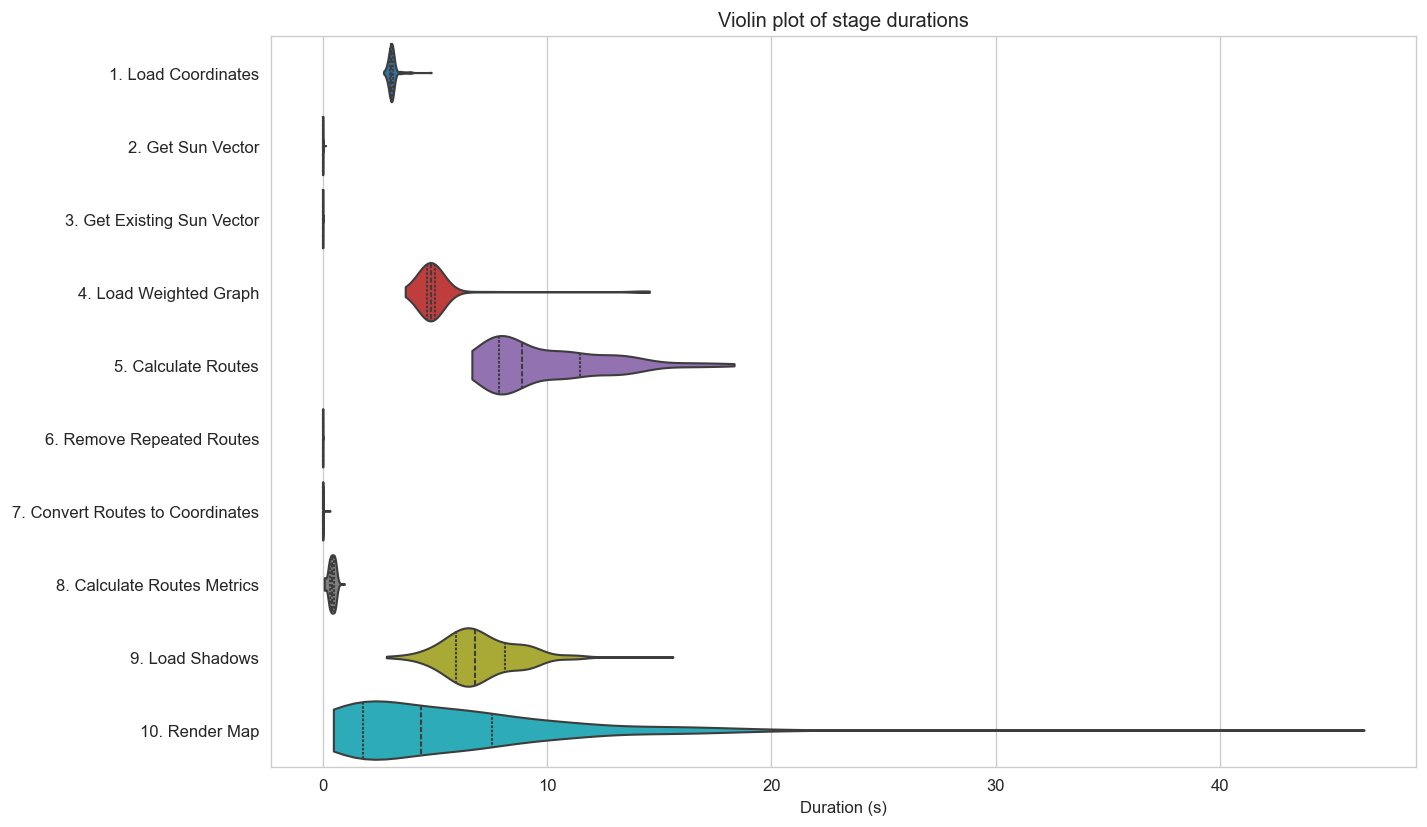

In [72]:
stages = df_proc.columns.tolist()[:-1]  # Exclude the last column (total_duration)
stage_labels = [stages_dict[stage] for stage in stages]

plt.figure(figsize=(12, 7), dpi=120)
sns.set_style("whitegrid")

sns.violinplot(
    data=df_proc[stages],
    inner="quartile",
    cut=0, # cut tails
    orient="h"
)
plt.yticks(range(len(stages)), stage_labels)  # Use the mapped stage names
plt.xlabel("Duration (s)")
plt.title("Violin plot of stage durations")
plt.tight_layout()
plt.show()

The violin plot shows that the most time-consuming and variable stages are `t05_calculate_routes`, `t09_load_shadows` and, above all, `t10_render_map`: although their medians sit between 6 s and 10 s, the distribution tails stretch to around 20 s for `t05_calculate_routes` and `t09_load_shadows`, and even up to 45 s for `t10_render_map`, indicating that rendering can spike dramatically in complex runs. The data-loading steps (`t01_load_coords`, `t04_load_weighted_graph`) have medians of about 5 s with moderate right-hand tails, suggesting occasional I/O slowdowns. In contrast, the lightweight stages—sun-vector retrieval (`t02_get_sun_vector`, `t03_get_existing_sun_vector`), route-cleaning (`t06_remove_repeated_routes`), coordinate conversion (`t07_convert_routes_to_coordinates`) and metrics computation (`t08_calculate_routes_metrics`)—cluster near zero with very little spread, confirming that they impose a minimal and consistent overhead.

Correlation heatmap

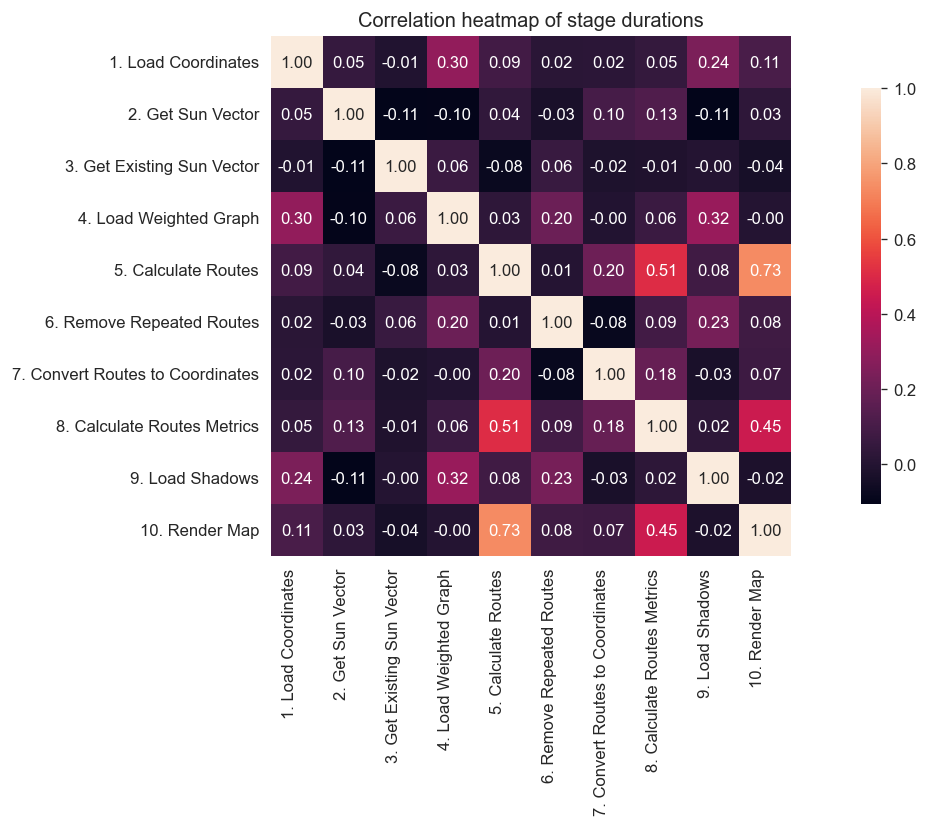

In [73]:
stages = df_proc.columns.tolist()[:-1] # Exclude total_duration
stage_labels = [stages_dict[stage] for stage in stages]

# Correlation matrix calculation
corr = df_proc[stages].corr()

plt.figure(figsize=(12, 7), dpi=120)
sns.set_style("whitegrid")

ax = sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    square=True,
    cbar_kws={'shrink': 0.8}
)

ax.set_xticks(np.arange(len(stage_labels)) + 0.5)
ax.set_xticklabels(stage_labels, rotation=90, ha='right')
ax.set_yticks(np.arange(len(stage_labels)) + 0.5)
ax.set_yticklabels(stage_labels, rotation=0)

plt.title("Correlation heatmap of stage durations")
plt.tight_layout()
plt.show()

The strongest positive relationships appear among the route-calculation (`t05_calculate_routes`), metrics-computation (`t08_calculate_routes_metrics`) and map-rendering (`t10_render_map`) stages, which fluctuate in unison (ρ > 0.5); when one of these steps is slow, the others tend to be slow as well. The data-loading phases (`t01_load_coords`, `t04_load_weighted_graph`, `t09_load_shadows`) exhibit moderate inter-correlations (ρ ≈ 0.3), so any I/O or preprocessing improvements will benefit several stages at once. In contrast, sun-vector retrieval (`t02_get_sun_vector`, `t03_get_existing_sun_vector`) and route-cleanup/conversion (`t06_remove_repeated_routes`, `t07_convert_routes_to_coordinates`) show virtually no coupling with the rest—reflecting their low, independent execution cost.

Note: that these are correlations of execution times, not direct measures of causal impact on overall performance.

**ECDF (Empirical Cumulative Distribution Function)**

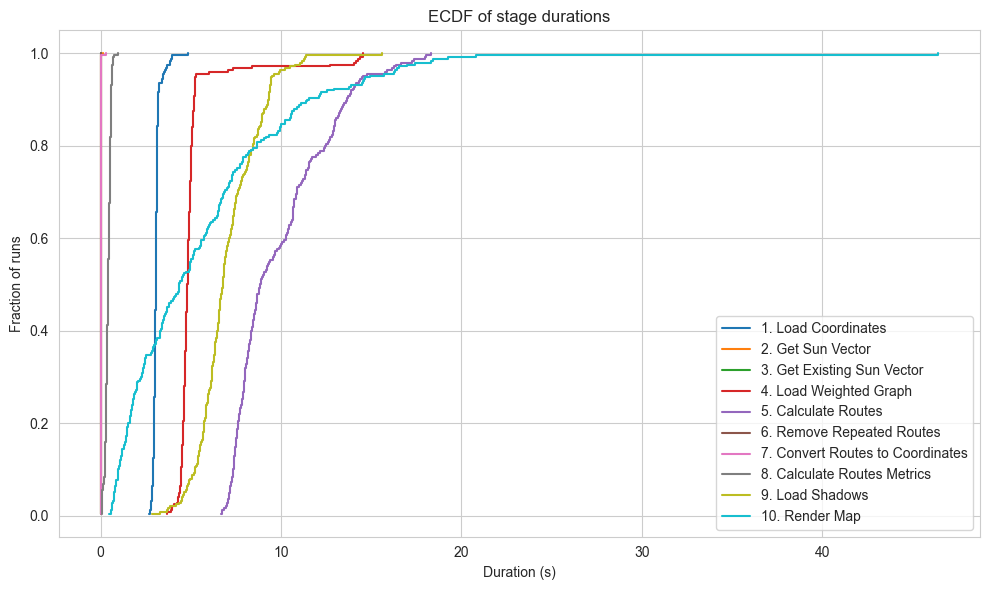

In [74]:
plt.figure(figsize=(10,6))
for st, label in zip(stages, stage_labels):
    x = np.sort(df_proc[st])
    y = np.arange(1, len(x)+1) / len(x)
    plt.step(x, y, where='post', label=label)
plt.xlabel("Duration (s)")
plt.ylabel("Fraction of runs")
plt.legend(loc='lower right')
plt.title("ECDF of stage durations")
plt.tight_layout()
plt.show()

The ECDF plot provides a clear, intuitive view of how quickly each stage completes across all runs. The stages `t02_get_sun_vector`, `t03_get_existing_sun_vector`, `t06_remove_repeated_routes`, and `t07_convert_routes_to_coordinates` stand out for their speed: nearly every execution finishes these steps almost instantly, with their curves shooting straight to 100%. This confirms that these lightweight preprocessing and cleanup phases are both extremely fast and highly consistent.

The `t08_calculate_routes_metrics` stage is also very predictable—over 90% of executions complete in less than half a second, and the steepness of its curve reflects minimal variability.

In contrast, the I/O-related stages, `t01_load_coords` and `t04_load_weighted_graph`, show more gradual slopes. Their medians are around 3.4 and 4.4 seconds, respectively, and while most runs finish quickly, the rightward tails of their curves reveal that occasional slowdowns do occur, likely due to disk or parsing delays.

The `t05_calculate_routes` stage is more variable: its median is near 8.5 seconds, but 10% of runs take longer than 15.5 seconds, indicating a wider spread in performance.

Finally, `t09_load_shadows` and especially `t10_render_map` display the most gradual, stretched-out ECDFs. While half of the rendering runs finish in about 5 seconds, a significant fraction take much longer—10% exceed 20 seconds, and a few outliers reach up to 45 seconds. This highlights both the high cost and unpredictability of these stages.

Overall, the steepness of each curve is a visual indicator of predictability: the steeper the curve, the less variable the stage. Lightweight and metrics stages are very stable, I/O steps are moderately variable, and route calculation and rendering are the most unpredictable and critical for benchmarking.


**Pareto Chart (bar plot sorted by mean time)**

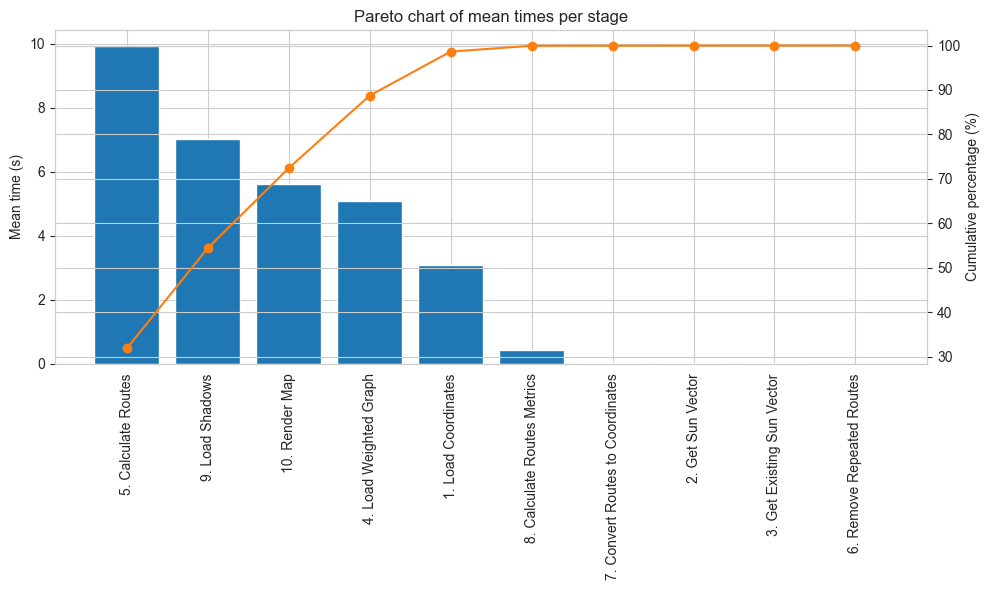

In [75]:
means = df_proc[stages].mean().sort_values(ascending=False)
cumperc = means.cumsum() / means.sum() * 100

# Use stage_labels sorted in the same order as means
sorted_labels = [stages_dict[stage] for stage in means.index]

fig, ax1 = plt.subplots(figsize=(10,6))
ax1.bar(sorted_labels, means.values)
ax1.set_ylabel("Mean time (s)")
ax1.tick_params(axis='x', rotation=90)

ax2 = ax1.twinx()
ax2.plot(sorted_labels, cumperc, marker='o', color='C1')
ax2.set_ylabel("Cumulative percentage (%)")

plt.title("Pareto chart of mean times per stage")
plt.tight_layout()
plt.show()


The Pareto chart confirms that very few stages account for the vast majority of the average time:

`t05_calculate_routes` alone represents about 32% of the total.

Adding `t09_load_shadows` brings the sum to over half of the average time (~54%).

Including `t10_render_map` brings the cumulative total to nearly 72%.

Adding `t04_load_weighted_graph` raises the percentage to more than 88%, and with `t01_load_coords` we reach practically 100%.

In other words, the first three stages (`t05`, `t09`, `t10`) account for almost three-quarters of the average cost, and with a fourth (`t04`) we cover almost the entire total. The remaining steps contribute less than 12% combined, so focusing on optimizing those few critical phases should offer the greatest return on investment in your benchmarking.

**Stacked area chart of relative contribution**

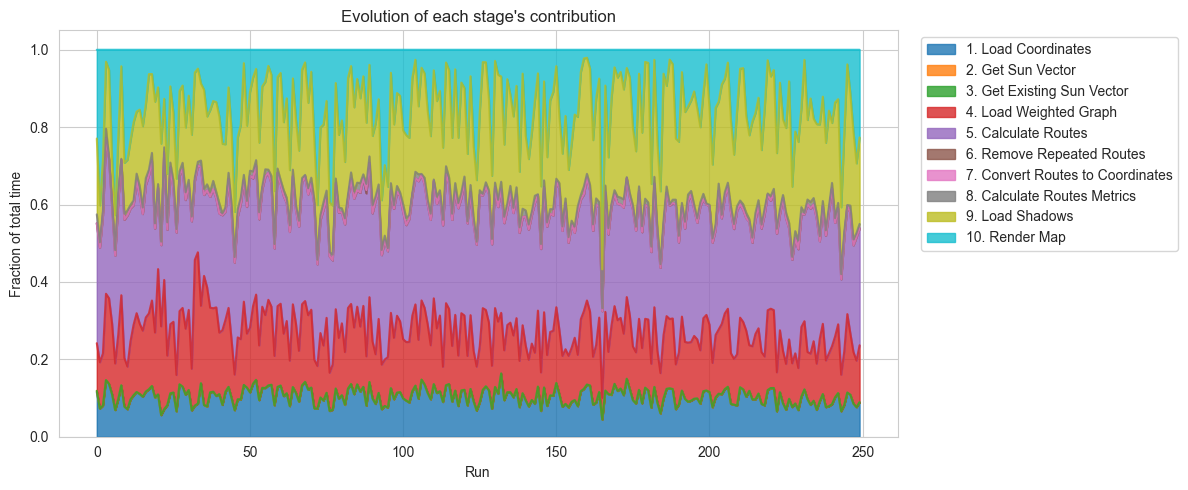

In [76]:
frac = df_proc[stages].div(df_proc['total_duration'], axis=0)
frac.columns = stage_labels
frac.plot.area(figsize=(12,5), alpha=0.8)
plt.legend(bbox_to_anchor=(1.02,1), loc='upper left')
plt.ylabel("Fraction of total time")
plt.xlabel("Run")
plt.title("Evolution of each stage's contribution")
plt.tight_layout()
plt.show()

The stacked area chart shows that, throughout the 250 runs, the relative proportions of each stage remain quite stable without major drift trends. At the bottom, we see that the lightweight steps (`t02_get_sun_vector`, `t03_get_existing_sun_vector`, `t06_remove_repeated_routes`, `t07_convert_routes_to_coordinates`, and `t08_calculate_routes_metrics`) together account for almost 5% of the total time, forming very thin bands. Coordinate loading (`t01_load_coords`) and graph loading (`t04_load_weighted_graph`) together make up around 15–18%, with occasional slight fluctuations suggesting sporadic I/O variations.

The widest band corresponds to `t05_calculate_routes`, which consistently represents between 20% and 25% of the total time, followed by `t09_load_shadows` (about 12–15%) and finally `t10_render_map` (between 10% and 20%, with variable peaks). Their relative width shows that route calculation is the dominant stage in almost every run, while rendering and shadow loading provide a secondary but still significant load. Overall, this diagram reinforces that optimizing mainly `t05`, `t09`, and `t10` will yield the greatest reduction in total time, since their contributions are not only the highest but also the most variable.

**Parallel coordinates**

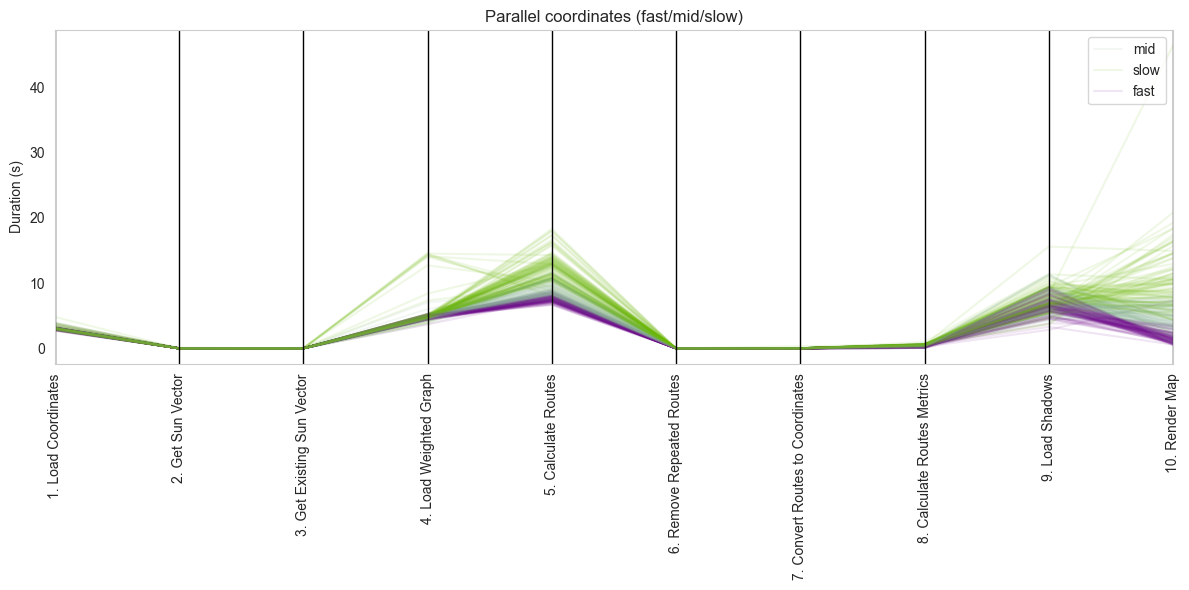

In [77]:
# Create a simple label: "Fast" vs "Slow" according to total_duration
df_pc = df_proc[stages + ['total_duration']].copy()
df_pc['group'] = pd.qcut(df_pc['total_duration'], 3, labels=['fast', 'mid', 'slow'])
plt.figure(figsize=(12,6))
parallel_coordinates(df_pc, 'group', cols=stages, alpha=0.1)
plt.xticks(range(len(stage_labels)), stage_labels, rotation=90)
plt.ylabel("Duration (s)")
plt.title("Parallel coordinates (fast/mid/slow)")
plt.tight_layout()
plt.show()

In the parallel coordinates diagram, it is clear that the “slow” executions (green lines) are distinguished by very pronounced peaks precisely in the most expensive stages—especially `t05_calculate_routes`, `t09_load_shadows`, and `t10_render_map`—while the “fast” ones (purple) remain very low on those same axes. The “mid” group falls in between in terms of height. In contrast, for the columns corresponding to the lightweight steps (`t02_get_sun_vector`, `t03_get_existing_sun_vector`, `t06_remove_repeated_routes`, `t07_convert_routes_to_coordinates`, `t08_calculate_routes_metrics`), all lines converge almost at 0, with no separation between groups. This confirms that the variability between executions is explained almost exclusively by the three key stages, and that their duration is the main discriminating factor for overall speed (fast vs. mid vs. slow).

**PCA + Scatter Analysis**

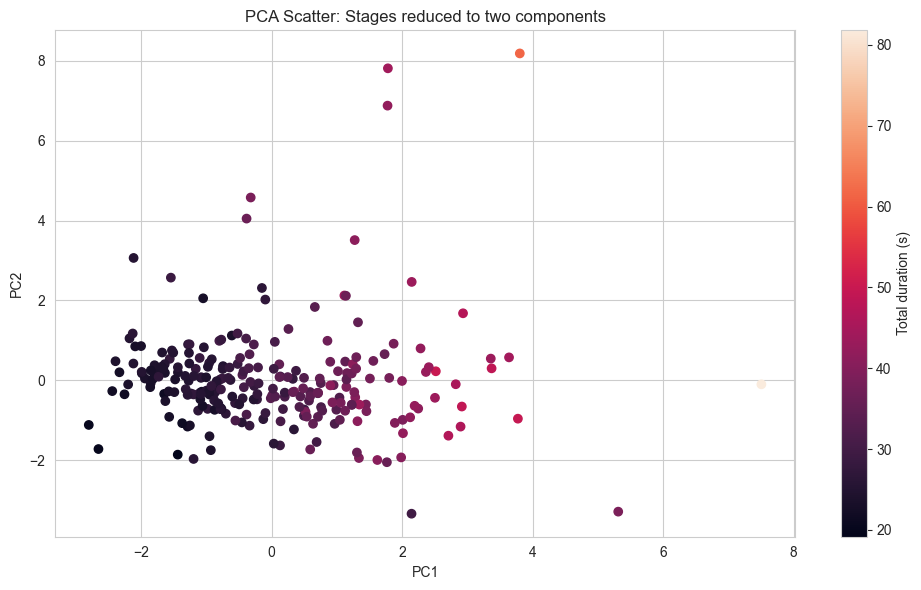

In [78]:
stages = df_proc.columns.tolist()[:-1]

# Transpose the DataFrame for PCA
X = df_proc[stages].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)

# Create a DataFrame with the principal components
pc_df = pd.DataFrame(principal_components, columns=['PC1', 'PC2'])
pc_df['total_duration'] = df_proc['total_duration'].values

plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    pc_df['PC1'],
    pc_df['PC2'],
    c=pc_df['total_duration']
)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Scatter: Stages reduced to two components')
plt.colorbar(scatter, label='Total duration (s)')
plt.tight_layout()
plt.show()


The PCA scatter plot clearly shows that the principal component `PC1` captures most of the variability related to the total execution time: the darkest points (fast runs, ~20–30 s) cluster toward negative or near-zero values of `PC1`, while the lightest points (slow runs, > 60 s) appear on the right, with `PC1` around 4–8. This confirms that `PC1` is strongly correlated with the heavy stages (route calculation, metrics, and rendering).

The second component, `PC2`, adds an additional nuance: although it is not as closely tied to the total time (the color range does not vary as systematically along `PC2`), it helps separate some runs with atypical behavior in specific stages. For example, there are a couple of points with `PC2` ≈ 8–9 (very high) that likely represent cases where graph or shadow loading was especially slow, and another with `PC2` ≈ –3 combined with high PC1, which could indicate an unusual drop in some preprocessing phase.

Overall, the PCA shows that almost all of the time “drift” is explained by `PC1` (differences in the sum of the most expensive stages), while `PC2` captures secondary variations or outliers in less dominant steps.